# Combine and QC MHC variants

Process output of SNP2HLA imputation and call alleles for each sample, for use in personalized HLA quantification pipeline.

Joyce Kang

**Includes xMHC variants imputed by SNP2HLA:**
- 1 and 2-field HLA alleles
- Intergenic SNPs
- Excludes HLA Amino Acids (AAs)
- Excludes intragenic SNPs

**Strategy:** Apply filters (MAF, R2) on a cohort-by-cohort basis, then intersect the filtered list from all cohorts to get the final list.

In [1]:
suppressPackageStartupMessages({
    library(vcfR)
    library(tidyr)
    library(ggplot2)
    library(dplyr)
    library(stringr)
    library(tidyverse)
})

source('../utils.R')

# Sample-level metadata
sample_meta_prefix = '../../data/meta/'
AMP2RA_sample_meta = read.csv(paste0(sample_meta_prefix, 'sample_meta_AMP2RA_completeHLA.csv'))
Smillie_sample_meta = read.csv(paste0(sample_meta_prefix, 'sample_meta_Smillie_completeHLA.csv'))
Randolph_sample_meta = read.csv(paste0(sample_meta_prefix, 'sample_meta_Randolph_completeHLA.csv'))
OneK1K_sample_meta = read.csv(paste0(sample_meta_prefix, 'sample_meta_OneK1K_completeHLA.csv'))

DR2_thresh = 0.8 # Imputation DR2 threshold

# Process AMP2RA

Because we had to lift the hg19 coordinates to hg38, we first check that REF and ALT same before and after lifting over.

In [2]:
hg19_vcf_path = '/data/srlab1/jkang/hla/data/AMP/AMP.final.SNP2HLA.imputed_MHC_hg19_chr_prefix.vcf'
hg38_vcf_path = '/data/srlab1/jkang/hla/data/AMP/AMP.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf'
vcf_hg19 = read.vcfR(hg19_vcf_path, verbose = F)
vcf_hg38 = read.vcfR(hg38_vcf_path, verbose = F)

vcf_hg19 = vcf_hg19@fix %>% as.data.frame() %>% select(ID, REF, ALT)
vcf_hg38 = vcf_hg38@fix %>% as.data.frame() %>% select(ID, REF, ALT)
for (i in 1:nrow(vcf_hg19)) {
    if(vcf_hg19[i, 'REF'] != vcf_hg38[i, 'REF'] & startsWith(vcf_hg19[i, 'ID'], 'rs')) {
        print(vcf_hg19[i, ])
        print(vcf_hg38[i, ])
    }
} # none of rsid SNPs got flipped

Subset to samples in the eQTL cohort

In [3]:
vcf = read.vcfR(hg38_vcf_path, verbose = F)
sample_meta = AMP2RA_sample_meta

# Subset to cohort samples
vcf
vcf@meta %>% head(4)
samples = c('FORMAT', sample_meta$Geno_ID)
vcf@gt = vcf@gt[, samples] # Subset to only samples in the eQTL cohort
vcf@gt %>% head(4)

***** Object of Class vcfR *****
788 samples
1 CHROMs
22,733 variants
Object size: 141.6 Mb
0 percent missing data
*****        *****         *****

[1] "##fileformat=VCFv4.2"                                                                                                                                              
[2] "##INFO=<ID=AF,Number=A,Type=Float,Description=\"Estimated ALT Allele Frequencies\">"                                                                               
[3] "##INFO=<ID=AR2,Number=1,Type=Float,Description=\"Allelic R-Squared: estimated squared correlation between most probable REF dose and true REF dose\">"             
[4] "##INFO=<ID=DR2,Number=1,Type=Float,Description=\"Dosage R-Squared: estimated squared correlation between estimated REF dose [P(RA) + 2*P(RR)] and true REF dose\">"

FORMAT,301-0267,300-0302,300-0150,300-0310,300-2663,300-0460,300-0309,300-1933,300-0228-V0-08-L1,⋯,301-1469,300-0151-V0-05-L1,300-0235-V0-08-L1,300-0415,300-0417,300-0418,300-1879-F2-17-L1,300-1880-F1-17-L1,300-0251,300-0464
GT:DS:GP,"1|1:2:0,0,1","0|0:0:1,0,0","0|1:1:0,1,0","0|1:1:0,1,0","1|1:2:0,0,1","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0",⋯,"0|1:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","1|0:1:0,1,0","0|0:0:1,0,0"
GT:DS:GP,"1|0:0.98:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.86:0.14,0.86,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.97:0.03,0.97,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


In [4]:
# How many of each type of variant are there?
substr(as.character(vcf@fix[, 'ID']), 1, 2) %>% unique()
which(startsWith(as.character(vcf@fix[, 'ID']), 'rs')) %>% length() # intergenic SNPs
which(startsWith(as.character(vcf@fix[, 'ID']), 'HLA')) %>% length() # alleles
which(startsWith(as.character(vcf@fix[, 'ID']), 'SNPS')) %>% length() # intragenic SNPs
which(startsWith(as.character(vcf@fix[, 'ID']), 'AA')) %>% length() # amino acids
which(startsWith(as.character(vcf@fix[, 'ID']), 'IN')) %>% length() # intragenic insertions/dels

[1] "rs" "HL" "SN" "AA" "IN"

[1] 14691

[1] 570

[1] 3947

[1] 3447

[1] 78

In [5]:
570+3447+3947+14691+78
3947+78

[1] 22733

[1] 4025

Calculate the new minor allele frequency (MAF) on the subset of samples

In [6]:
newMaf = maf(vcf)[, 'Frequency']

Format the fix region

In [7]:
geno_gt = vcf@gt # genotype dosages
geno_df = as.data.frame(vcf@fix) # information about each variant

# Replace asterix with period and colon with a period
geno_df$ID = stringr::str_replace(geno_df$ID, '\\*', '_')
geno_df$ID = stringr::str_replace_all(geno_df$ID, ':', '.')
geno_df[which(startsWith(geno_df$ID, 'HLA_A_03.01')),]

# Split INFO column into constituent columns
geno_df = separate(data = geno_df, col = INFO, into = c("AR2", "DR2", "AF", "Imputed"), sep = ";")
geno_df$AR2 = sub('.*=', '', geno_df$AR2) %>% as.numeric()
geno_df$DR2 = sub('.*=', '', geno_df$DR2) %>% as.numeric()
geno_df$AF = sub('.*=', '', geno_df$AF) %>% as.numeric()
geno_df$newMAF = newMaf
geno_df$Imputed[which(is.na(geno_df$Imputed))] = 'TYPED' # change NA to TYPED
geno_df %>% head(4)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2986,chr6,29942496,HLA_A_03.01,C,T,NA,PASS,AR2=0.96;DR2=0.97;AF=0.080;IMP


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 9147 rows [14, 16, 19, 38, 43, 50, 51, 54, 62, 63, 73, 74, 81, 84, 89, 91, 92, 93, 97, 102, ...].”


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.98,0.98,0.270,IMP,0.22463768
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.95,0.95,0.051,IMP,0.02898551
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.90,0.92,0.120,IMP,0.06521739
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.89,0.91,0.060,IMP,0.05797101


Two of the "INS" variants are for amino acids

In [8]:
geno_df %>% filter(grepl('AA', ID) & ! startsWith(ID, 'AA'))

CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
chr6,31270015,INS_AA_C_300x301_31237792,A,T,NA,PASS,0.91,0.91,0.978,IMP,0.02898551
chr6,31355165,INS_AA_B_294x295_31322942,T,T,NA,PASS,0.00,0.00,0.998,IMP,0.00000000


Remove AAs and intragenic SNPs

In [9]:
idx_HLA_AAs = which(startsWith(geno_df$ID, 'INS_AA') | startsWith(geno_df$ID, 'AA'))
idx_HLA_alleles = which(startsWith(geno_df$ID, 'HLA'))
idx_HLA_intra = which(startsWith(geno_df$ID, 'INS_SNPS') | startsWith(geno_df$ID, 'SNPS'))
length(idx_HLA_AAs)
length(idx_HLA_alleles)
length(idx_HLA_intra)

# Remove AA variants and intragenic SNPs
geno_df = geno_df[-c(idx_HLA_AAs, idx_HLA_intra), ]
geno_gt = geno_gt[-c(idx_HLA_AAs, idx_HLA_intra), ]

table(geno_df$Imputed)

[1] 3449

[1] 570

[1] 4023


  IMP TYPED 
 6116  9145 

Filter by variants with DR^2 > 0.8, MAF > 0.01.

In [10]:
keep_variants_idx = which(geno_df$newMAF > 0.01 & geno_df$DR2 > DR2_thresh)
geno_gt = geno_gt[keep_variants_idx, ]
geno_df = geno_df[keep_variants_idx, ]

geno_df %>% arrange(-AF) %>% head(5)
dim(geno_df)
table(geno_df$Imputed)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,33925736,rs2147428,T,G,NA,PASS,1.0,1.00,0.975,TYPED,0.06521739
2,chr6,29397010,rs3128853,C,T,NA,PASS,0.9,0.91,0.974,IMP,0.03623188
3,chr6,29312861,rs3117431,A,G,NA,PASS,1.0,1.00,0.968,TYPED,0.02173913
4,chr6,29355482,rs3117438,G,A,NA,PASS,1.0,1.00,0.968,TYPED,0.02173913
5,chr6,30711851,rs3094093,T,A,NA,PASS,1.0,1.00,0.968,TYPED,0.06521739


[1] 13815    12


  IMP TYPED 
 4916  8899 

Rename to sample IDs

In [11]:
colnames(geno_gt) = plyr::mapvalues(colnames(geno_gt), 
                                    sample_meta$Geno_ID, sample_meta$Sample, warn_missing = TRUE)

Extract dosage info (takes a few mins)

In [12]:
get_dosage = function(st) { return(strsplit(st, ":")[[1]][2]) }
geno_dosage = apply(geno_gt, c(1,2), get_dosage)
dim(geno_df)
dim(geno_dosage)
rownames(geno_dosage) = geno_df$ID
geno_dosage = geno_dosage %>% t()
geno_dosage = geno_dosage[-1, ] #Remove FORMAT row
geno_dosage[1:5, 1:5]

[1] 13815    12

[1] 13815    70

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540
BRI-399,2,0.98,0,0,0
BRI-401,0,0,0,0,0
BRI-403,1,0,0,0,0
BRI-405,1,0,0,0,0
BRI-407,2,1,0,0,0


Get AMP2RA samples and reorder to match sample_meta

In [13]:
all(rownames(geno_dosage) == AMP2RA_sample_meta$Sample)

# Reorder to match sample_meta
geno_dosage_AMP2RA = geno_dosage[AMP2RA_sample_meta$Sample, ]
geno_dosage_AMP2RA[1:4, 1:4] # sample X dosage

geno_df_AMP2RA = geno_df
head(geno_df_AMP2RA)

[1] TRUE

,rs149946,rs9380032,rs4141691,rs10484402
BRI-399,2,0.98,0,0
BRI-401,0,0,0,0
BRI-403,1,0,0,0
BRI-405,1,0,0,0


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.98,0.98,0.270,IMP,0.22463768
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.95,0.95,0.051,IMP,0.02898551
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.90,0.92,0.120,IMP,0.06521739
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.89,0.91,0.060,IMP,0.05797101
5,chr6,28013895,rs9368540,G,A,NA,PASS,0.92,0.93,0.050,IMP,0.05072464
7,chr6,28017129,rs17765055,T,C,NA,PASS,0.95,0.95,0.057,IMP,0.07246377


# Process Smillie2019

## ccdg_broad

Subset to cohort samples

In [14]:
hg38_path = '/data/srlab1/jkang/hla/data/Smillie2019/Smillie2019_ccdg_broad.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf'
vcf = read.vcfR(hg38_path, verbose = F)

# Only include samples genotyped on this array
sample_meta = Smillie_sample_meta[which(Smillie_sample_meta$Geno_ID %in% colnames(vcf@gt)), ]
nrow(sample_meta)

# Subset to cohort samples
vcf
vcf@meta %>% head(4)
samples = c('FORMAT', sample_meta$Geno_ID)
vcf@gt = vcf@gt[, colnames(vcf@gt) %in% samples]
vcf@gt %>% head(4)

[1] 14

***** Object of Class vcfR *****
765 samples
1 CHROMs
22,733 variants
Object size: 137.7 Mb
0 percent missing data
*****        *****         *****

[1] "##fileformat=VCFv4.2"                                                                                                                                              
[2] "##INFO=<ID=AF,Number=A,Type=Float,Description=\"Estimated ALT Allele Frequencies\">"                                                                               
[3] "##INFO=<ID=AR2,Number=1,Type=Float,Description=\"Allelic R-Squared: estimated squared correlation between most probable REF dose and true REF dose\">"             
[4] "##INFO=<ID=DR2,Number=1,Type=Float,Description=\"Dosage R-Squared: estimated squared correlation between estimated REF dose [P(RA) + 2*P(RR)] and true REF dose\">"

FORMAT,202279080102_R08C01,202279080112_R06C01,202279080112_R09C02,202596060040_R04C02,202596060059_R06C01,202596060059_R09C02,202596060089_R01C01,202596060155_R06C01,202596060155_R09C02,203259090242_R05C02,203281950204_R10C02,203281950211_R02C01,203281950211_R10C02,203672280128_R03C01
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.96:0.04,0.96,0","1|1:2:0,0,1","0|0:0:1,0,0","1|0:0.9:0.1,0.89,0","1|0:1:0,1,0","0|0:0:1,0,0","0|0:0.03:0.97,0.03,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0.02:0.98,0.02,0","0|1:0.78:0.22,0.78,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.97:0.03,0.96,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0.03:0.97,0.03,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


Format the fix region

In [15]:
geno_gt = vcf@gt
geno_df = as.data.frame(vcf@fix)

# Replace asterix with period
geno_df$ID = stringr::str_replace(geno_df$ID, '\\*', '_')
geno_df$ID = stringr::str_replace_all(geno_df$ID, ':', '.')
geno_df[which(startsWith(geno_df$ID, 'HLA_A_03.01')),]

# Split column info
geno_df = separate(data = geno_df, col = INFO, into = c("AR2", "DR2", "AF", "Imputed"), sep = ";")
geno_df$AR2 = sub('.*=', '', geno_df$AR2) %>% as.numeric()
geno_df$DR2 = sub('.*=', '', geno_df$DR2) %>% as.numeric()
geno_df$AF = sub('.*=', '', geno_df$AF) %>% as.numeric()
geno_df$Imputed[which(is.na(geno_df$Imputed))] = 'TYPED'
geno_df %>% head(4)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2986,chr6,29942496,HLA_A_03.01,C,T,NA,PASS,AR2=0.98;DR2=0.98;AF=0.13;IMP


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 7168 rows [13, 15, 17, 18, 20, 22, 27, 30, 41, 44, 45, 47, 50, 52, 54, 56, 57, 62, 64, 65, ...].”


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.96,0.96,0.220,IMP
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.93,0.93,0.039,IMP
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.89,0.90,0.110,IMP
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.93,0.93,0.043,IMP


Remove AAs and intragenic SNPs

In [16]:
idx_HLA_AAs = which(startsWith(geno_df$ID, 'INS_AA') | startsWith(geno_df$ID, 'AA'))
idx_HLA_alleles = which(startsWith(geno_df$ID, 'HLA'))
idx_HLA_intra = which(startsWith(geno_df$ID, 'INS_SNPS') | startsWith(geno_df$ID, 'SNPS'))
length(idx_HLA_AAs)
length(idx_HLA_alleles)
length(idx_HLA_intra)

# Remove AA variants and intragenic SNPs
geno_df = geno_df[-c(idx_HLA_AAs, idx_HLA_intra), ]
geno_gt = geno_gt[-c(idx_HLA_AAs, idx_HLA_intra), ]

table(geno_df$Imputed)

[1] 3449

[1] 570

[1] 4023


  IMP TYPED 
 8101  7160 

Filter by variants with DR^2 > 0.8

In [17]:
keep_variants_idx = which(geno_df$DR2 > DR2_thresh)
geno_gt = geno_gt[keep_variants_idx, ]
geno_df = geno_df[keep_variants_idx, ]

geno_df %>% arrange(-AF) %>% head(5)
dim(geno_df)
table(geno_df$Imputed)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,chr6,33640602,rs4713647,T,C,NA,PASS,0.84,0.84,0.985,IMP
2,chr6,28375144,rs6916243,T,C,NA,PASS,0.90,0.90,0.982,IMP
3,chr6,28609953,rs7382159,A,C,NA,PASS,0.89,0.89,0.982,IMP
4,chr6,28631251,rs4711176,G,A,NA,PASS,0.89,0.89,0.982,IMP
5,chr6,28639174,rs4713172,T,C,NA,PASS,0.89,0.89,0.982,IMP


[1] 13993    11


  IMP TYPED 
 6833  7160 

Rename to sample IDs

In [18]:
colnames(geno_gt) = plyr::mapvalues(colnames(geno_gt), 
                                    sample_meta$Geno_ID, sample_meta$Sample, warn_missing = TRUE)

Extract dosage info (takes a few mins)

In [19]:
get_dosage = function(st) { return(strsplit(st, ":")[[1]][2]) }
geno_dosage = apply(geno_gt, c(1,2), get_dosage)
dim(geno_df)
dim(geno_dosage)
rownames(geno_dosage) = geno_df$ID
geno_dosage = geno_dosage %>% t()

[1] 13993    11

[1] 13993    15

In [20]:
geno_dosage = geno_dosage[-1, ] #Remove FORMAT row
geno_dosage[1:5, 1:5]

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540
N24,0,0,0,0,0
N10,0,0,0,0,0
N13,0,0,0,1,1
N19,0.96,0,0,0,0
N16,2,1,0,0,0


Get Smillie_1 samples and reorder to match sample_meta

In [21]:
# Reorder to match sample_meta
geno_dosage_Smillie_1 = geno_dosage[sample_meta$Sample, ]
geno_dosage_Smillie_1[1:4, 1:4] # sample X dosage
geno_df_Smillie_1 = geno_df

,rs149946,rs9380032,rs4141691,rs10484402
N24,0,0,0,0
N10,0,0,0,0
N13,0,0,0,1
N19,0.96,0,0,0


## Helmsley_merged

Subset to cohort samples

In [22]:
hg38_path = '/data/srlab1/jkang/hla/data/Smillie2019/Smillie2019_Hemsley.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf'
vcf = read.vcfR(hg38_path, verbose = F)

# Only include samples genotyped on this array
sample_meta = Smillie_sample_meta[which(Smillie_sample_meta$Geno_ID %in% colnames(vcf@gt)), ]
nrow(sample_meta)

# Subset to cohort samples
vcf
vcf@meta %>% head(4)
samples = c('FORMAT', sample_meta$Geno_ID)
vcf@gt = vcf@gt[, colnames(vcf@gt) %in% samples]
vcf@gt %>% head(4)

[1] 8

***** Object of Class vcfR *****
2121 samples
1 CHROMs
22,733 variants
Object size: 373.6 Mb
0 percent missing data
*****        *****         *****

[1] "##fileformat=VCFv4.2"                                                                                                                                              
[2] "##INFO=<ID=AF,Number=A,Type=Float,Description=\"Estimated ALT Allele Frequencies\">"                                                                               
[3] "##INFO=<ID=AR2,Number=1,Type=Float,Description=\"Allelic R-Squared: estimated squared correlation between most probable REF dose and true REF dose\">"             
[4] "##INFO=<ID=DR2,Number=1,Type=Float,Description=\"Dosage R-Squared: estimated squared correlation between estimated REF dose [P(RA) + 2*P(RR)] and true REF dose\">"

FORMAT,200554340014_R04C01,200554340055_R04C02,200554340071_R09C02,200556970036_R05C02,200556970061_R03C01,200556970131_R07C01,200557060156_R09C02,200557070016_R12C02
GT:DS:GP,"0|0:0:1,0,0","1|0:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","1|1:2:0,0,1","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"1|0:0.93:0.1,0.87,0.03","0|0:0:1,0,0","1|1:1.82:0.01,0.17,0.82","0|0:0:1,0,0","1|1:1.81:0.01,0.17,0.82","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


Format the fix region

In [23]:
geno_gt = vcf@gt
geno_df = as.data.frame(vcf@fix)

# Replace asterix with period
geno_df$ID = stringr::str_replace(geno_df$ID, '\\*', '_')
geno_df$ID = stringr::str_replace_all(geno_df$ID, ':', '.')
geno_df[which(startsWith(geno_df$ID, 'HLA_A_03.01')),]

# Split column info
geno_df = separate(data = geno_df, col = INFO, into = c("AR2", "DR2", "AF", "Imputed"), sep = ";")
geno_df$AR2 = sub('.*=', '', geno_df$AR2) %>% as.numeric()
geno_df$DR2 = sub('.*=', '', geno_df$DR2) %>% as.numeric()
geno_df$AF = sub('.*=', '', geno_df$AF) %>% as.numeric()
geno_df$Imputed[which(is.na(geno_df$Imputed))] = 'TYPED'
geno_df %>% head(4)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2986,chr6,29942496,HLA_A_03.01,C,T,NA,PASS,AR2=0.97;DR2=0.97;AF=0.12;IMP


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 709 rows [14, 43, 73, 102, 139, 165, 189, 203, 212, 236, 253, 256, 268, 271, 274, 280, 281, 298, 366, 371, ...].”


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.96,0.97,0.220,IMP
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.83,0.85,0.035,IMP
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.85,0.86,0.110,IMP
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.83,0.85,0.037,IMP


Remove AAs and intragenic SNPs

In [24]:
idx_HLA_AAs = which(startsWith(geno_df$ID, 'INS_AA') | startsWith(geno_df$ID, 'AA'))
idx_HLA_alleles = which(startsWith(geno_df$ID, 'HLA'))
idx_HLA_intra = which(startsWith(geno_df$ID, 'INS_SNPS') | startsWith(geno_df$ID, 'SNPS'))
length(idx_HLA_AAs)
length(idx_HLA_alleles)
length(idx_HLA_intra)

# Remove AA variants and intragenic SNPs
geno_df = geno_df[-c(idx_HLA_AAs, idx_HLA_intra), ]
geno_gt = geno_gt[-c(idx_HLA_AAs, idx_HLA_intra), ]

table(geno_df$Imputed)

[1] 3449

[1] 570

[1] 4023


  IMP TYPED 
14552   709 

Filter by variants with DR^2 > 0.8

In [25]:
keep_variants_idx = which(geno_df$DR2 > DR2_thresh)
geno_gt = geno_gt[keep_variants_idx, ]
geno_df = geno_df[keep_variants_idx, ]

geno_df %>% arrange(-AF) %>% head(5)
dim(geno_df)
table(geno_df$Imputed)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,chr6,28652420,rs7382309,A,G,NA,PASS,0.80,0.81,0.989,IMP
2,chr6,33640602,rs4713647,T,C,NA,PASS,0.83,0.85,0.982,IMP
3,chr6,33642573,rs4711333,A,G,NA,PASS,0.84,0.86,0.978,IMP
4,chr6,28609953,rs7382159,A,C,NA,PASS,0.91,0.91,0.974,IMP
5,chr6,28631251,rs4711176,G,A,NA,PASS,0.92,0.92,0.974,IMP


[1] 13853    11


  IMP TYPED 
13144   709 

Rename to sample IDs

In [26]:
colnames(geno_gt) = plyr::mapvalues(colnames(geno_gt), sample_meta$Geno_ID, sample_meta$Sample, warn_missing = TRUE)

Extract dosage info (takes a few mins)

In [27]:
get_dosage = function(st) { return(strsplit(st, ":")[[1]][2]) }
geno_dosage = apply(geno_gt, c(1,2), get_dosage)
dim(geno_df)
dim(geno_dosage)
rownames(geno_dosage) = geno_df$ID
geno_dosage = geno_dosage %>% t()

[1] 13853    11

[1] 13853     9

In [28]:
geno_dosage = geno_dosage[-1, ] #Remove FORMAT row
geno_dosage[1:2, 1:5]

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540
P9539,0,0,0.93,0,0
P9106,1,0,0,0,0


Get Smillie_2 samples and reorder to match sample_meta

In [29]:
# Reorder to match sample_meta
geno_dosage_Smillie_2 = geno_dosage[sample_meta$Sample, ]
geno_dosage_Smillie_2[1:4, 1:4] # sample X dosage
geno_df_Smillie_2 = geno_df

,rs149946,rs9380032,rs4141691,rs10484402
N14,0,0,0,0
N23,1,0,0,0
N7,0,0,1.81,0
P8661,2,0,0,0


## Combine Smillie Samples

In [30]:
dim(geno_dosage_Smillie_1)
dim(geno_dosage_Smillie_2)

intersecting_variants = intersect(colnames(geno_dosage_Smillie_1), colnames(geno_dosage_Smillie_2))
length(intersecting_variants)

[1]    14 13993

[1]     8 13853

[1] 13734

Match the ordering of Smillie sample metadata

In [31]:
geno_dosage_Smillie_1 = geno_dosage_Smillie_1[, intersecting_variants]
geno_dosage_Smillie_2 = geno_dosage_Smillie_2[, intersecting_variants]

geno_dosage_Smillie = rbind(geno_dosage_Smillie_1, geno_dosage_Smillie_2)
geno_dosage_Smillie = geno_dosage_Smillie[Smillie_sample_meta$Sample, ]

Calculate the new minor allele frequency on the subset of samples

In [32]:
dim(geno_dosage_Smillie)
class(geno_dosage_Smillie) = 'numeric'
AF = Matrix::colSums(geno_dosage_Smillie) / (2*nrow(geno_dosage_Smillie))
MAF = ifelse(AF < 0.5, AF, 1-AF)
to_keep = which(MAF > 0.01) %>% names()
geno_dosage_Smillie = geno_dosage_Smillie[, to_keep]
dim(geno_dosage_Smillie)

[1]    22 13734

[1]    22 12531

In [33]:
geno_df_Smillie_1 = geno_df_Smillie_1 %>% filter(ID %in% to_keep)
geno_df_Smillie_2 = geno_df_Smillie_2 %>% filter(ID %in% to_keep)
table(geno_df_Smillie_1$Imputed)


  IMP TYPED 
 6263  6268 

Save a new column (MAF_Smillie) with MAF across all Smillie eQTL cohort samples

In [34]:
geno_df_Smillie = geno_df_Smillie_1
AF = Matrix::colSums(geno_dosage_Smillie) / (2*nrow(geno_dosage_Smillie))
MAF = ifelse(AF < 0.5, AF, 1-AF)
geno_df_Smillie$newMAF = MAF
head(geno_df_Smillie)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.96,0.96,0.220,IMP,0.22477273
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.93,0.93,0.039,IMP,0.02272727
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.89,0.90,0.110,IMP,0.14386364
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.93,0.93,0.043,IMP,0.02340909
5,chr6,28013895,rs9368540,G,A,NA,PASS,0.95,0.95,0.052,IMP,0.02272727
6,chr6,28017129,rs17765055,T,C,NA,PASS,0.95,0.95,0.057,IMP,0.02272727


# Randolph2021

Subset to cohort samples

In [35]:
hg38_path = '/data/srlab1/jkang/hla/data/Randolph2021/Randolph2021.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf'
vcf = read.vcfR(hg38_path, verbose = F)

# Only include samples genotyped on this array
sample_meta = Randolph_sample_meta

# Subset to cohort samples
vcf
vcf@meta %>% head(4)
samples = c('FORMAT', sample_meta$Geno_ID)
vcf@gt = vcf@gt[, colnames(vcf@gt) %in% samples]
vcf@gt %>% head(4)

***** Object of Class vcfR *****
90 samples
1 CHROMs
22,733 variants
Object size: 20.4 Mb
0 percent missing data
*****        *****         *****

[1] "##fileformat=VCFv4.2"                                                                                                                                              
[2] "##INFO=<ID=AF,Number=A,Type=Float,Description=\"Estimated ALT Allele Frequencies\">"                                                                               
[3] "##INFO=<ID=AR2,Number=1,Type=Float,Description=\"Allelic R-Squared: estimated squared correlation between most probable REF dose and true REF dose\">"             
[4] "##INFO=<ID=DR2,Number=1,Type=Float,Description=\"Dosage R-Squared: estimated squared correlation between estimated REF dose [P(RA) + 2*P(RR)] and true REF dose\">"

FORMAT,HMN171216,HMN171217,HMN171218,HMN171219,HMN171220,HMN171221,HMN171222,HMN171223,HMN171224,⋯,HMN83568,HMN83569,HMN83570,HMN83571,HMN83572,HMN83574,HMN83575,HMN83576,HMN83577,HMN83580
GT:DS:GP,"1|0:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","1|1:2:0,0,1",⋯,"1|0:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","1|1:2:0,0,1","1|0:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","1|0:0.71:0.29,0.71,0","0|0:0:1,0,0","0|1:0.97:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","1|0:0.97:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.97:0.03,0.96,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.73:0.27,0.72,0","0|0:0:1,0,0","0|0:0:1,0,0"


Calculate the new minor allele frequency on the subset of samples

In [36]:
newMaf = maf(vcf)[, 'Frequency']

Format the fix region

In [37]:
geno_gt = vcf@gt
geno_df = as.data.frame(vcf@fix)

# Replace asterix with period
geno_df$ID = stringr::str_replace(geno_df$ID, '\\*', '_')
geno_df$ID = stringr::str_replace_all(geno_df$ID, ':', '.')
geno_df[which(startsWith(geno_df$ID, 'HLA_A_03.01')),]

# Split column info
geno_df = separate(data = geno_df, col = INFO, into = c("AR2", "DR2", "AF", "Imputed"), sep = ";")
geno_df$AR2 = sub('.*=', '', geno_df$AR2) %>% as.numeric()
geno_df$DR2 = sub('.*=', '', geno_df$DR2) %>% as.numeric()
geno_df$AF = sub('.*=', '', geno_df$AF) %>% as.numeric()
geno_df$Imputed[which(is.na(geno_df$Imputed))] = 'TYPED'
geno_df$newMAF = newMaf
geno_df %>% head(4)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2986,chr6,29942496,HLA_A_03.01,C,T,NA,PASS,AR2=0.87;DR2=0.91;AF=0.081;IMP


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 10751 rows [14, 15, 19, 21, 23, 24, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, ...].”


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.99,0.99,0.320,IMP,0.36301370
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.83,0.85,0.020,IMP,0.02054795
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.90,0.91,0.160,IMP,0.18493151
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.88,0.88,0.054,IMP,0.03424658


Remove AAs and intragenic SNPs

In [38]:
idx_HLA_AAs = which(startsWith(geno_df$ID, 'INS_AA') | startsWith(geno_df$ID, 'AA'))
idx_HLA_alleles = which(startsWith(geno_df$ID, 'HLA'))
idx_HLA_intra = which(startsWith(geno_df$ID, 'INS_SNPS') | startsWith(geno_df$ID, 'SNPS'))
length(idx_HLA_AAs)
length(idx_HLA_alleles)
length(idx_HLA_intra)

# Remove AA variants and intragenic SNPs
geno_df = geno_df[-c(idx_HLA_AAs, idx_HLA_intra), ]
geno_gt = geno_gt[-c(idx_HLA_AAs, idx_HLA_intra), ]

table(geno_df$Imputed)

[1] 3449

[1] 570

[1] 4023


  IMP TYPED 
 4638 10623 

Filter by variants with DR^2 > 0.8, MAF > 0.01.

In [39]:
keep_variants_idx = which(geno_df$newMAF > 0.01 & geno_df$DR2 > DR2_thresh)
geno_gt = geno_gt[keep_variants_idx, ]
geno_df = geno_df[keep_variants_idx, ]

geno_df %>% arrange(-AF) %>% head(5)
dim(geno_df)
table(geno_df$Imputed)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,30801701,rs3129988,T,C,NA,PASS,0.81,0.83,0.972,IMP,0.02739726
2,chr6,31096528,rs565615223,A,G,NA,PASS,0.92,0.92,0.971,IMP,0.02739726
3,chr6,31097843,rs2256962,A,G,NA,PASS,0.92,0.92,0.971,IMP,0.02739726
4,chr6,29826724,rs3115630,T,C,NA,PASS,0.93,0.93,0.970,IMP,0.03424658
5,chr6,30060083,rs3132129,A,G,NA,PASS,0.92,0.92,0.970,IMP,0.03424658


[1] 13806    12


  IMP TYPED 
 3183 10623 

Extract dosage info (takes a few mins)

In [40]:
get_dosage = function(st) { return(strsplit(st, ":")[[1]][2]) }
geno_dosage = apply(geno_gt, c(1,2), get_dosage)
dim(geno_df)
dim(geno_dosage)
rownames(geno_dosage) = geno_df$ID
geno_dosage = geno_dosage %>% t()

geno_dosage = geno_dosage[-1, ] #Remove FORMAT row
geno_dosage[1:5, 1:5]

[1] 13806    12

[1] 13806    74

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540
HMN171216,1,0,0,0,0
HMN171217,0,0,0,0,0
HMN171218,0,0,0.98,0,0
HMN171219,1,0,0,0,0
HMN171220,0,0,0.71,0,0


Get Randolph samples and reorder to match sample_meta

In [41]:
unique(sample_meta$Geno_ID)

[1] "HMN83551"  "HMN83552"  "HMN83553"  "HMN83558"  "HMN83559"  "HMN83556" 
 [7] "HMN83560"  "HMN83561"  "HMN83562"  "HMN83555"  "HMN83565"  "HMN83568" 
[13] "HMN83569"  "HMN83570"  "HMN83564"  "HMN83567"  "HMN83563"  "HMN83566" 
[19] "HMN83571"  "HMN83572"  "HMN83575"  "HMN83576"  "HMN83577"  "HMN83574" 
[25] "HMN83580"  "HMN52538"  "HMN52536"  "HMN52537"  "HMN52533"  "HMN52534" 
[31] "HMN52544"  "HMN52558"  "HMN52535"  "HMN52543"  "HMN52540"  "HMN52539" 
[37] "HMN52541"  "HMN52551"  "HMN52553"  "HMN52554"  "HMN52560"  "HMN52547" 
[43] "HMN52546"  "HMN52548"  "HMN52550"  "HMN52555"  "HMN171229" "HMN171218"
[49] "HMN171220" "HMN171233" "HMN171232" "HMN171231" "HMN171234" "HMN171240"
[55] "HMN171216" "HMN171219" "HMN171221" "HMN171222" "HMN171224" "HMN171226"
[61] "HMN171239" "HMN171242" "HMN171237" "HMN171238" "HMN171243" "HMN171244"
[67] "HMN171223" "HMN171225" "HMN171217" "HMN171235" "HMN171236" "HMN171241"
[73] "HMN171227"

In [42]:
# Reorder to match sample_meta
geno_dosage_Randolph = geno_dosage[unique(sample_meta$Geno_ID), ]
geno_dosage_Randolph %>% head(4) # sample X dosage
geno_df_Randolph = geno_df
geno_df_Randolph %>% head(4)

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540,rs74505854,rs17765055,rs72848791,rs9368544,rs149990,⋯,rs2495978,rs6911089,rs78132888,rs2499762,rs2499763,rs2499766,rs2495988,rs11970492,rs73406709,rs76403141
HMN83551,0,0,0.79,0,0,0,0,0,0,0,⋯,1,0,0,1,1,0.71,0.01,0,0,0
HMN83552,0,0,0,0,0,0,0,0,0,0,⋯,2,2,0,0,2,1.96,0.08,0,0,0
HMN83553,1,0,0,0,0,0,0,1,0,0,⋯,2,0,0,2,2,1.98,0,0,0,0
HMN83558,2,0,0,0,0,0,0,0,0,1,⋯,2,1,0,0,2,0.86,1.29,0,0,1


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.99,0.99,0.320,IMP,0.36301370
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.83,0.85,0.020,IMP,0.02054795
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.90,0.91,0.160,IMP,0.18493151
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.88,0.88,0.054,IMP,0.03424658


# OneK1K

Subset to cohort samples

In [43]:
hg38_path = '/data/srlab1/jkang/hla/data/OneK1K/OneK1K.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf'
vcf = read.vcfR(hg38_path, verbose = F)

# Only include samples genotyped on this array
sample_meta = OneK1K_sample_meta

# Subset to cohort samples
vcf
vcf@meta %>% head(4)
samples = c('FORMAT', sample_meta$Geno_ID)
vcf@gt = vcf@gt[, colnames(vcf@gt) %in% samples]
vcf@gt %>% head(4)

***** Object of Class vcfR *****
972 samples
1 CHROMs
22,733 variants
Object size: 173.5 Mb
0 percent missing data
*****        *****         *****

[1] "##fileformat=VCFv4.2"                                                                                                                                              
[2] "##INFO=<ID=AF,Number=A,Type=Float,Description=\"Estimated ALT Allele Frequencies\">"                                                                               
[3] "##INFO=<ID=AR2,Number=1,Type=Float,Description=\"Allelic R-Squared: estimated squared correlation between most probable REF dose and true REF dose\">"             
[4] "##INFO=<ID=DR2,Number=1,Type=Float,Description=\"Dosage R-Squared: estimated squared correlation between estimated REF dose [P(RA) + 2*P(RR)] and true REF dose\">"

FORMAT,1_1,2_2,3_3,4_4,6_6,7_7,8_8,9_9,10_10,⋯,1072_1073,1073_1074,1074_1075,1075_1076,1076_1077,1078_1079,1079_1080,1080_1081,1081_1082,241_242
GT:DS:GP,"0|0:0:1,0,0","1|1:1.96:0,0.04,0.96","0|1:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","1|0:1:0,1,0","0|0:0:1,0,0",⋯,"0|1:0.77:0.23,0.77,0","1|1:2:0,0,1","0|0:0:1,0,0","1|0:0.96:0.04,0.96,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","1|0:0.97:0.03,0.96,0","1|0:0.95:0.06,0.94,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.97:0.03,0.96,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


Calculate the new minor allele frequency on the subset of samples

In [44]:
newMaf = maf(vcf)[, 'Frequency']

Format the fix region

In [45]:
geno_gt = vcf@gt
geno_df = as.data.frame(vcf@fix)

# Replace asterix with period
geno_df$ID = stringr::str_replace(geno_df$ID, '\\*', '_')
geno_df$ID = stringr::str_replace_all(geno_df$ID, ':', '.')
geno_df[which(startsWith(geno_df$ID, 'HLA_A_03.01')),]

# Split column info
geno_df = separate(data = geno_df, col = INFO, into = c("AR2", "DR2", "AF", "Imputed"), sep = ";")
geno_df$AR2 = sub('.*=', '', geno_df$AR2) %>% as.numeric()
geno_df$DR2 = sub('.*=', '', geno_df$DR2) %>% as.numeric()
geno_df$AF = sub('.*=', '', geno_df$AF) %>% as.numeric()
geno_df$Imputed[which(is.na(geno_df$Imputed))] = 'TYPED'
geno_df$newMAF = newMaf
geno_df %>% head(4)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2986,chr6,29942496,HLA_A_03.01,C,T,NA,PASS,AR2=0.98;DR2=0.98;AF=0.14;IMP


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 6689 rows [13, 15, 17, 18, 20, 22, 27, 30, 41, 44, 45, 47, 50, 52, 54, 56, 57, 62, 64, 65, ...].”


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.96,0.96,0.220,IMP,0.22882288
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.90,0.90,0.022,IMP,0.02090209
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.87,0.89,0.091,IMP,0.09295930
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.92,0.92,0.034,IMP,0.03300330


Remove AAs and intragenic SNPs

In [46]:
idx_HLA_AAs = which(startsWith(geno_df$ID, 'INS_AA') | startsWith(geno_df$ID, 'AA'))
idx_HLA_alleles = which(startsWith(geno_df$ID, 'HLA'))
idx_HLA_intra = which(startsWith(geno_df$ID, 'INS_SNPS') | startsWith(geno_df$ID, 'SNPS'))
length(idx_HLA_AAs)
length(idx_HLA_alleles)
length(idx_HLA_intra)

# Remove AA variants and intragenic SNPs
geno_df = geno_df[-c(idx_HLA_AAs, idx_HLA_intra), ]
geno_gt = geno_gt[-c(idx_HLA_AAs, idx_HLA_intra), ]

table(geno_df$Imputed)

[1] 3449

[1] 570

[1] 4023


  IMP TYPED 
 8577  6684 

Filter by variants with DR^2 > 0.8, MAF > 0.01.

In [47]:
keep_variants_idx = which(geno_df$newMAF > 0.01 & geno_df$DR2 > DR2_thresh)
geno_gt = geno_gt[keep_variants_idx, ]
geno_df = geno_df[keep_variants_idx, ]

geno_df %>% arrange(-AF) %>% head(5)
dim(geno_df)
table(geno_df$Imputed)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,33642573,rs4711333,A,G,NA,PASS,0.84,0.84,0.987,IMP,0.01210121
2,chr6,28609953,rs7382159,A,C,NA,PASS,0.90,0.90,0.980,IMP,0.01815182
3,chr6,28631251,rs4711176,G,A,NA,PASS,0.90,0.90,0.980,IMP,0.01815182
4,chr6,28639174,rs4713172,T,C,NA,PASS,0.90,0.90,0.980,IMP,0.01815182
5,chr6,28638620,rs10807036,G,A,NA,PASS,0.93,0.93,0.969,IMP,0.02970297


[1] 13440    12


  IMP TYPED 
 6767  6673 

Extract dosage info (takes a few mins)

In [48]:
get_dosage = function(st) { return(strsplit(st, ":")[[1]][2]) }
geno_dosage = apply(geno_gt, c(1,2), get_dosage)
dim(geno_df)
dim(geno_dosage)
rownames(geno_dosage) = geno_df$ID
geno_dosage = geno_dosage %>% t()

geno_dosage = geno_dosage[-1, ] #Remove FORMAT row
geno_dosage[1:5, 1:5]

[1] 13440    12

[1] 13440   910

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540
1_1,0,0,0,0,0
2_2,1.96,0,0,0,0
3_3,1,0,0,0,0
4_4,1,0,0.98,0,0
6_6,1,0,0,0,0


Get OneK1K samples and reorder to match sample_meta

In [49]:
# Reorder to match sample_meta
geno_dosage_OneK1K = geno_dosage[unique(sample_meta$Geno_ID), ]
geno_dosage_OneK1K %>% head(4) # sample X dosage

,rs149946,rs9380032,rs4141691,rs10484402,rs9368540,rs17765055,rs72848791,rs9368544,rs149990,rs9368545,⋯,rs6911089,rs78132888,rs2499762,rs2499763,rs2499766,rs2495988,rs17531174,rs2495993,rs73406709,rs76403141
691_692,0.95,0,0,0,0,0,0.95,0,0,0,⋯,0.21,0.76,0,0.21,0.96,0,0,1,0,0
693_694,0,0,0,1,1,1,0,1,0,1,⋯,0,0,0,0,0.01,0,0,0,0,0
688_689,1,0,0,0,0,0,0,0,0,0,⋯,0,0,2,2,1.8,0,0,0,0,0
683_684,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,1,1,0,0,0,0,0


In [50]:
geno_df_OneK1K = geno_df
head(geno_df_OneK1K)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,AR2,DR2,AF,Imputed,newMAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,chr6,28002253,rs149946,G,T,NA,PASS,0.96,0.96,0.220,IMP,0.22882288
2,chr6,28008422,rs9380032,G,T,NA,PASS,0.90,0.90,0.022,IMP,0.02090209
3,chr6,28011410,rs4141691,A,G,NA,PASS,0.87,0.89,0.091,IMP,0.09295930
4,chr6,28011847,rs10484402,A,G,NA,PASS,0.92,0.92,0.034,IMP,0.03300330
5,chr6,28013895,rs9368540,G,A,NA,PASS,0.93,0.94,0.040,IMP,0.03905391
7,chr6,28017129,rs17765055,T,C,NA,PASS,0.94,0.95,0.050,IMP,0.05060506


# Intersect all cohorts

In [51]:
dim(geno_dosage_AMP2RA)
dim(geno_dosage_Smillie)
dim(geno_dosage_Randolph)
dim(geno_dosage_OneK1K)

intersecting_variants = colnames(geno_dosage_AMP2RA) %>% 
                        intersect(colnames(geno_dosage_Smillie)) %>% intersect(colnames(geno_dosage_Randolph)) %>%
                        intersect(colnames(geno_dosage_OneK1K))
length(intersecting_variants)

[1]    69 13815

[1]    22 12531

[1]    73 13806

[1]   909 13440

[1] 12050

Did any HLA alleles make it through the QC?

In [52]:
a = intersecting_variants[which(startsWith(intersecting_variants, 'HLA'))]
length(a)
a

[1] 112

[1] "HLA_A_01"       "HLA_A_01.01"    "HLA_A_02"       "HLA_A_02.01"   
  [5] "HLA_A_03"       "HLA_A_03.01"    "HLA_A_11"       "HLA_A_23"      
  [9] "HLA_A_23.01"    "HLA_A_24"       "HLA_A_24.02"    "HLA_A_29"      
 [13] "HLA_A_29.02"    "HLA_A_68"       "HLA_A_68.01"    "HLA_C_01"      
 [17] "HLA_C_01.02"    "HLA_C_02"       "HLA_C_02.02"    "HLA_C_03"      
 [21] "HLA_C_03.03"    "HLA_C_03.04"    "HLA_C_04"       "HLA_C_04.01"   
 [25] "HLA_C_05"       "HLA_C_05.01"    "HLA_C_06"       "HLA_C_06.02"   
 [29] "HLA_C_07"       "HLA_C_07.01"    "HLA_C_07.02"    "HLA_C_07.04"   
 [33] "HLA_C_08"       "HLA_C_08.02"    "HLA_C_12"       "HLA_C_12.03"   
 [37] "HLA_C_16"       "HLA_C_16.01"    "HLA_B_07"       "HLA_B_07.02"   
 [41] "HLA_B_08"       "HLA_B_08.01"    "HLA_B_14"       "HLA_B_15"      
 [45] "HLA_B_15.01"    "HLA_B_27"       "HLA_B_27.05"    "HLA_B_35"      
 [49] "HLA_B_35.01"    "HLA_B_35.03"    "HLA_B_38"       "HLA_B_44"      
 [53] "HLA_B_44.02"    "HLA_B_44.03"    "HLA_B_51"       "HLA_B_51.01"   
 [57] "HLA_B_57"       "HLA_B_57.01"    "HLA_DRB1_01"    "HLA_DRB1_03"   
 [61] "HLA_DRB1_03.01" "HLA_DRB1_04"    "HLA_DRB1_07"    "HLA_DRB1_07.01"
 [65] "HLA_DRB1_08"    "HLA_DRB1_11"    "HLA_DRB1_11.01" "HLA_DRB1_13"   
 [69] "HLA_DRB1_13.01" "HLA_DRB1_15"    "HLA_DRB1_15.01" "HLA_DQA1_01"   
 [73] "HLA_DQA1_01.01" "HLA_DQA1_01.02" "HLA_DQA1_01.03" "HLA_DQA1_02"   
 [77] "HLA_DQA1_02.01" "HLA_DQA1_03"    "HLA_DQA1_03.01" "HLA_DQA1_04"   
 [81] "HLA_DQA1_04.01" "HLA_DQA1_05"    "HLA_DQA1_05.01" "HLA_DQB1_02"   
 [85] "HLA_DQB1_02.01" "HLA_DQB1_03"    "HLA_DQB1_03.01" "HLA_DQB1_03.02"
 [89] "HLA_DQB1_03.03" "HLA_DQB1_04"    "HLA_DQB1_04.02" "HLA_DQB1_05"   
 [93] "HLA_DQB1_05.01" "HLA_DQB1_06"    "HLA_DQB1_06.02" "HLA_DQB1_06.03"
 [97] "HLA_DPA1_01"    "HLA_DPA1_01.03" "HLA_DPA1_02"    "HLA_DPA1_02.01"
[101] "HLA_DPA1_02.02" "HLA_DPB1_01"    "HLA_DPB1_01.01" "HLA_DPB1_02"   
[105] "HLA_DPB1_02.01" "HLA_DPB1_03"    "HLA_DPB1_03.01" "HLA_DPB1_04"   
[109] "HLA_DPB1_04.01" "HLA_DPB1_04.02" "HLA_DPB1_13"    "HLA_DPB1_13.01"

In [53]:
geno_dosage_AMP2RA = geno_dosage_AMP2RA[, intersecting_variants]
geno_dosage_Smillie = geno_dosage_Smillie[, intersecting_variants]
geno_dosage_Randolph = geno_dosage_Randolph[, intersecting_variants] 
geno_dosage_OneK1K = geno_dosage_OneK1K[, intersecting_variants] 
class(geno_dosage_AMP2RA) = 'numeric'
class(geno_dosage_Smillie) = 'numeric'
class(geno_dosage_Randolph) = 'numeric'
class(geno_dosage_OneK1K) = 'numeric'

geno_df_AMP2RA = geno_df_AMP2RA %>% filter(ID %in% intersecting_variants)
geno_df_Smillie = geno_df_Smillie %>% filter(ID %in% intersecting_variants)
geno_df_Randolph = geno_df_Randolph %>% filter(ID %in% intersecting_variants)
geno_df_OneK1K = geno_df_OneK1K %>% filter(ID %in% intersecting_variants)

Confirmed that all REF/ALT is the same between the cohorts

## Plot histogram of MAF

[1]    69 12050

[1]    22 12050

[1]    73 12050

[1]   909 12050

[1]  1073 12050

[1] 0.01127679

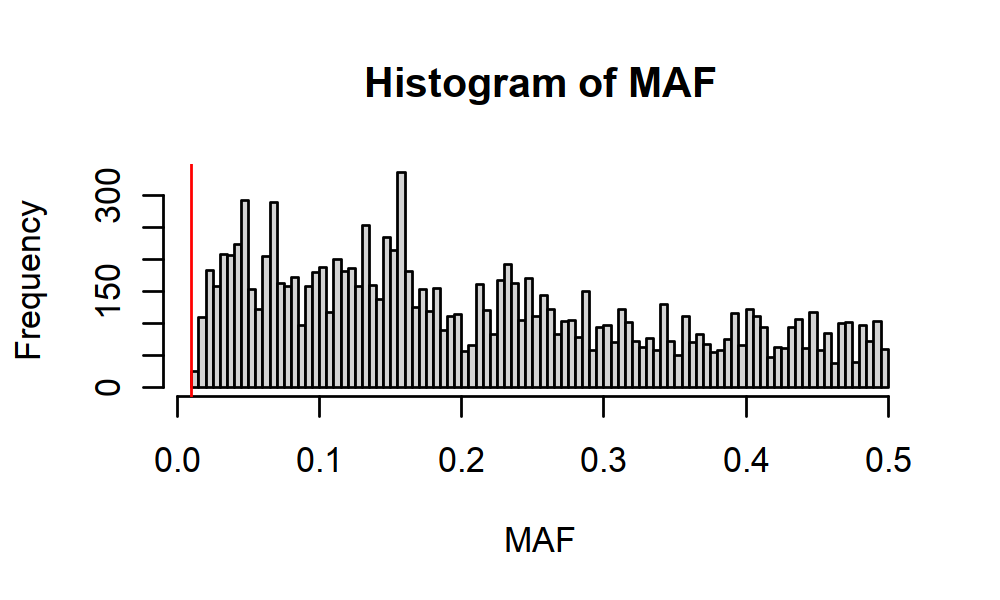

In [54]:
dim(geno_dosage_AMP2RA)
dim(geno_dosage_Smillie)
dim(geno_dosage_Randolph)
dim(geno_dosage_OneK1K)
geno_dosage_all = rbind(geno_dosage_AMP2RA, geno_dosage_Smillie, geno_dosage_Randolph, geno_dosage_OneK1K)
dim(geno_dosage_all)

AF = Matrix::colSums(geno_dosage_all) / (2*nrow(geno_dosage_all))
MAF = ifelse(AF < 0.5, AF, 1-AF)
fig.size(3, 5)
hist(MAF, breaks = 100)
abline(v=0.01,col="red",lwd=1)
min(MAF)

In [55]:
# Save sampleXdosage
dir = '../../data/sampleXdosage/'
saveRDS(geno_dosage_AMP2RA, paste0(dir, 'AMP2RA_sampleXdosage_final.rds'))
saveRDS(geno_dosage_Smillie,paste0(dir, 'Smillie2019_sampleXdosage_final.rds'))
saveRDS(geno_dosage_Randolph, paste0(dir, 'Randolph2021_sampleXdosage_final.rds'))
saveRDS(geno_dosage_OneK1K, paste0(dir, 'OneK1K_sampleXdosage_final.rds'))

# Save variant info
saveRDS(geno_df_AMP2RA, paste0(dir, 'AMP2RA_variant_info_final.rds'))
saveRDS(geno_df_Smillie, paste0(dir, 'Smillie2019_variant_info_final.rds'))
saveRDS(geno_df_Randolph, paste0(dir, 'Randolph2021_variant_info_final.rds'))
saveRDS(geno_df_OneK1K, paste0(dir, 'OneK1K_variant_info_final.rds'))

## Add cohort MAFs to variant info

In [56]:
variantInfo = geno_df_AMP2RA %>% dplyr::select(CHROM, POS, ID, REF, ALT, DR2, Imputed)

# Add cohort-specific MAFs
variantInfo$AMP2RA_MAF = geno_df_AMP2RA$newMAF
variantInfo$Smillie_MAF = geno_df_Smillie$newMAF
variantInfo$Randolph_MAF = geno_df_Randolph$newMAF
variantInfo$OneK1K_MAF = geno_df_OneK1K$newMAF

variantInfo %>% head()
saveRDS(variantInfo, paste0(dir, 'four_cohorts_variant_info_final.rds'))

,CHROM,POS,ID,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr6,28002253,rs149946,G,T,0.98,IMP,0.22463768,0.22477273,0.36301370,0.22882288
2,chr6,28008422,rs9380032,G,T,0.95,IMP,0.02898551,0.02272727,0.02054795,0.02090209
3,chr6,28011410,rs4141691,A,G,0.92,IMP,0.06521739,0.14386364,0.18493151,0.09295930
4,chr6,28011847,rs10484402,A,G,0.91,IMP,0.05797101,0.02340909,0.03424658,0.03300330
5,chr6,28013895,rs9368540,G,A,0.93,IMP,0.05072464,0.02272727,0.01369863,0.03905391
6,chr6,28017129,rs17765055,T,C,0.95,IMP,0.07246377,0.02272727,0.01369863,0.05060506


In [57]:
dir = '../../data/sampleXdosage/'
variantInfo = readRDS(paste0(dir, 'four_cohorts_variant_info_final.rds'))

Count how many of each variant type

In [58]:
variantInfo %>% filter(startsWith(ID, 'HLA')) %>% nrow()
variantInfo %>% filter(startsWith(ID, 'SNPS')) %>% nrow()
variantInfo %>% filter(startsWith(ID, 'INS')) %>% nrow()
variantInfo %>% filter(startsWith(ID, 'rs')) %>% nrow()
variantInfo %>% filter(startsWith(ID, 'AA')) %>% nrow()

[1] 112

[1] 0

[1] 0

[1] 11938

[1] 0

Plot POS distribution across MHC

png 
  2

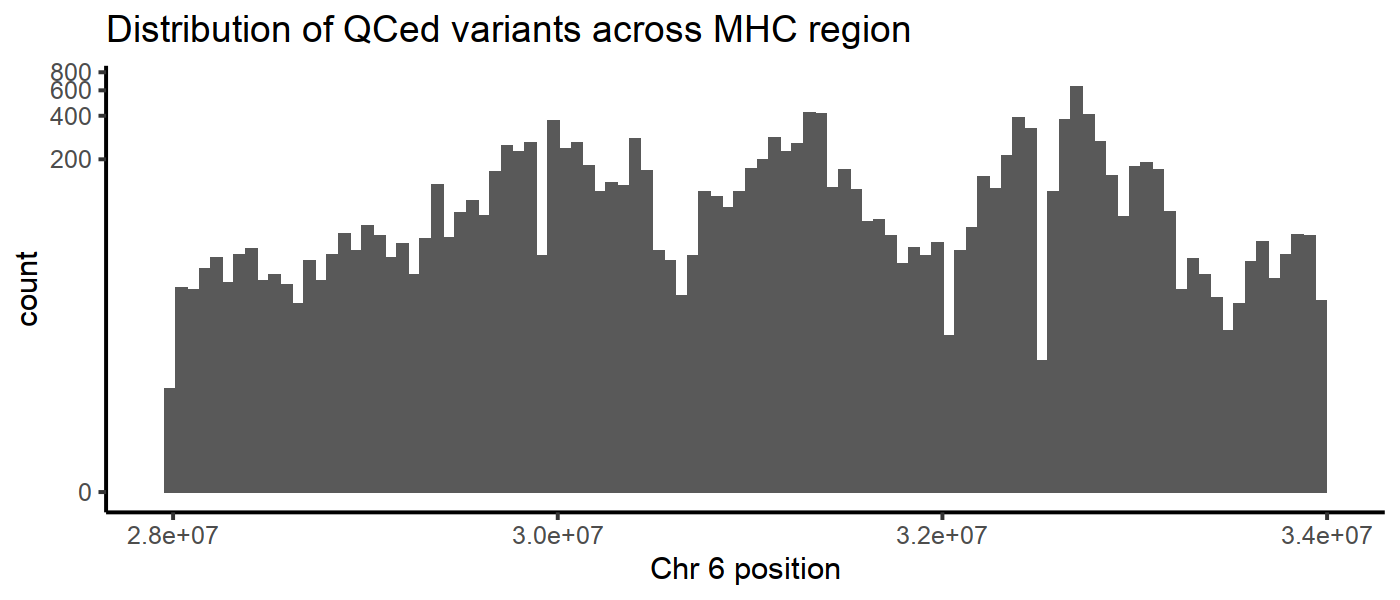

In [59]:
fig.size(3, 7)
pdf('../../SuppFigs/variant_distributions_MHC_Allvariants.pdf', width = 7, height = 3)
p = variantInfo %>% 
    ggplot() +
    geom_histogram(aes(x = as.numeric(POS)), size = 0.2, bins = 100) + theme_classic() +
    ggtitle('Distribution of QCed variants across MHC region') +
    xlab('Chr 6 position') + scale_y_continuous(trans=scales::pseudo_log_trans(base = 2))
print(p)
dev.off()
p

# Double check integrity of lifting SNPs variants over

Looks like for rs variants, REF/ALT are carried over after liftover.

For HLA allele and intragenic variants, some REFs got changed.

In [60]:
vcf_SNP2HLA = read.vcfR('/data/srlab1/jkang/hla/data/Randolph2021/Randolph2021.final.SNP2HLA.imputed_MHC_hg19_chr_prefix.vcf', verbose = F)
vcf_liftedOver = read.vcfR('/data/srlab1/jkang/hla/data/Randolph2021/Randolph2021.final.SNP2HLA.imputed_MHC_hg38_lifted_over.vcf', verbose = F)

In [61]:
sum(startsWith(vcf_SNP2HLA@fix[, 'ID'], 'HLA')) + sum(startsWith(vcf_SNP2HLA@fix[, 'ID'], 'SNPS'))
sum(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] )
vcf_SNP2HLA@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ), 'ID'] %>% startsWith('rs') %>% any() 
# no rs got flipped
vcf_SNP2HLA@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ), 'ID'] %>% startsWith('SNPS') %>% any() 
# some SNPS got flipped
vcf_SNP2HLA@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ), 'ID'] %>% startsWith('HLA') %>% any() 
# some HLA alleles got flipped
vcf_SNP2HLA@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ), 'ID'] %>% startsWith('AA') %>% any() 
# some AAs got flipped

[1] 4517

[1] 5488

[1] FALSE

[1] TRUE

[1] TRUE

[1] TRUE

In [62]:
# Example variants where REF was changed
vcf_SNP2HLA@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ),] %>% head(4)
vcf_liftedOver@fix[which(vcf_SNP2HLA@fix[, 'REF'] != vcf_liftedOver@fix[, 'REF'] ),] %>% head(4)
all(vcf_SNP2HLA@fix[,'ALT'] == vcf_liftedOver@fix[,'ALT']) # ALT values did not get changed

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
chr6,29910247,HLA_A*01,A,T,NA,PASS,AR2=0.93;DR2=0.94;AF=0.11;IMP
chr6,29910249,HLA_A*01:02,A,T,NA,PASS,AR2=0.68;DR2=0.68;AF=0.0075;IMP
chr6,29910252,HLA_A*02:01,A,T,NA,PASS,AR2=0.94;DR2=0.94;AF=0.20;IMP
chr6,29910253,HLA_A*02:02,A,T,NA,PASS,AR2=0.85;DR2=0.85;AF=0.013;IMP


CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
chr6,29942470,HLA_A*01,G,T,NA,PASS,AR2=0.93;DR2=0.94;AF=0.11;IMP
chr6,29942472,HLA_A*01:02,G,T,NA,PASS,AR2=0.68;DR2=0.68;AF=0.0075;IMP
chr6,29942475,HLA_A*02:01,G,T,NA,PASS,AR2=0.94;DR2=0.94;AF=0.20;IMP
chr6,29942476,HLA_A*02:02,C,T,NA,PASS,AR2=0.85;DR2=0.85;AF=0.013;IMP


[1] TRUE

## Carry over the original REF allele

Fix the REF/ALT and POS in the variant info

In [63]:
dir = '/data/srlab1/jkang/hla/data/combined_AMP_Randolph_Smillie/sampleXdosage/'
variantInfo = readRDS(paste0(dir, 'four_cohorts_variant_info_final.rds'))

message('Before fix')
variantInfo %>% filter(startsWith(ID, 'HLA')) %>% tail(2)

# Change colons and asteriks in HLA allele names
vcf_SNP2HLA@fix[, 'ID'] = stringr::str_replace_all(vcf_SNP2HLA@fix[,'ID'], ':', '.')
vcf_SNP2HLA@fix[, 'ID'] = stringr::str_replace(vcf_SNP2HLA@fix[, 'ID'], '\\*', '_')

variantInfo$hg19_POS = 0
for (i in 1:nrow(variantInfo)) {
    idx_match = which(vcf_SNP2HLA@fix[, 'ID'] == variantInfo$ID[i])
    if (length(idx_match) > 1) { message('more than one variant matched') }
    if (length(idx_match) == 0) { message('no variant matched') }
    variantInfo$REF[i] = vcf_SNP2HLA@fix[idx_match, 'REF']
    variantInfo$hg19_POS[i] = vcf_SNP2HLA@fix[idx_match, 'POS']
}

message('After fix')
variantInfo %>% filter(startsWith(ID, 'HLA')) %>% tail(2)

saveRDS(variantInfo, paste0(dir, 'four_cohorts_variant_info_final.rds'))

Before fix



,CHROM,POS,ID,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
111,chr6,33075950,HLA_DPB1_13,A,T,0.9,IMP,0.05072464,0.02272727,0.03424658,0.01925193,33043727
112,chr6,33075953,HLA_DPB1_13.01,A,T,0.9,IMP,0.05072464,0.02272727,0.03424658,0.01925193,33043730


After fix



,CHROM,POS,ID,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
111,chr6,33075950,HLA_DPB1_13,A,T,0.9,IMP,0.05072464,0.02272727,0.03424658,0.01925193,33043727
112,chr6,33075953,HLA_DPB1_13.01,A,T,0.9,IMP,0.05072464,0.02272727,0.03424658,0.01925193,33043730


# Write supp table

In [71]:
variantInfo$Imputed = NULL
variantInfo$Synovium_MAF = round(variantInfo$AMP2RA_MAF, 3)
variantInfo$Intestine_MAF = round(variantInfo$Smillie_MAF, 3)
variantInfo$PBMC_cultured_MAF = round(variantInfo$Randolph_MAF, 3)
variantInfo$PBMC_blood_MAF = round(variantInfo$OneK1K_MAF, 3)

variantInfo$AMP2RA_MAF = NULL
variantInfo$Smillie_MAF = NULL
variantInfo$Randolph_MAF = NULL
variantInfo$OneK1K_MAF = NULL
head(variantInfo)

,CHROM,POS,ID,REF,ALT,DR2,hg19_POS,Synovium_MAF,Intestine_MAF,PBMC_cultured_MAF,PBMC_blood_MAF
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr6,28002253,rs149946,G,T,0.98,27970031,0.225,0.225,0.363,0.229
2,chr6,28008422,rs9380032,G,T,0.95,27976200,0.029,0.023,0.021,0.021
3,chr6,28011410,rs4141691,A,G,0.92,27979188,0.065,0.144,0.185,0.093
4,chr6,28011847,rs10484402,A,G,0.91,27979625,0.058,0.023,0.034,0.033
5,chr6,28013895,rs9368540,G,A,0.93,27981673,0.051,0.023,0.014,0.039
6,chr6,28017129,rs17765055,T,C,0.95,27984907,0.072,0.023,0.014,0.051


In [75]:
write.csv(variantInfo, '../../SuppTables/four_cohorts_variant_info_final.csv', quote = F, row.names = F)

# Make two separate matrices for Randolph flu and NI samples

In [76]:
geno_dosage_Randolph = readRDS(paste0(dir, 'Randolph2021_sampleXdosage_final.rds'))
geno_dosage_Randolph[1:2, 1:2]
flu = geno_dosage_Randolph
rownames(flu) = paste0(rownames(flu), '_flu')
NI = geno_dosage_Randolph
rownames(NI) = paste0(rownames(NI), '_NI')
saveRDS(flu, paste0(dir, 'Randolph_flu_sampleXdosage_final.rds'))
saveRDS(NI, paste0(dir, 'Randolph_NI_sampleXdosage_final.rds'))

,rs149946,rs9380032
HMN83551,0,0
HMN83552,0,0


# All done!

In [74]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1   purrr_0.3.4     readr_2.1.2     tibble_3.1.6   
 [5] tidyverse_1.3.1 stringr_1.4.0   dplyr_1.0.8     ggplot2_3.3.5  
 [9] tidyr_1.2.0     vcfR_1.12.0    

loaded via a namespace (and not attached):
 [1] httr_1.4.4        jsonlite_1.8.4    viridi